In [1]:
import os
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

import matplotlib.pyplot as plt
import torch
import matplotlib.pylab as pylab
from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
import gwot
import sim
import gwot.bridgesampling as bs
# import dcor


sys.path.append("fig1_batch")
import importlib
import models
import pred_models
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
device

PLT_CELL = 2.5

In [2]:
# set random seed
SRAND = 0
torch.manual_seed(SRAND)
np.random.seed(SRAND)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# train_2 from https://www.kaggle.com/competitions/web-traffic-time-series-forecasting
data = pd.read_csv('../mfl_code/train_2.csv')
data = data.dropna()


(3, 803)


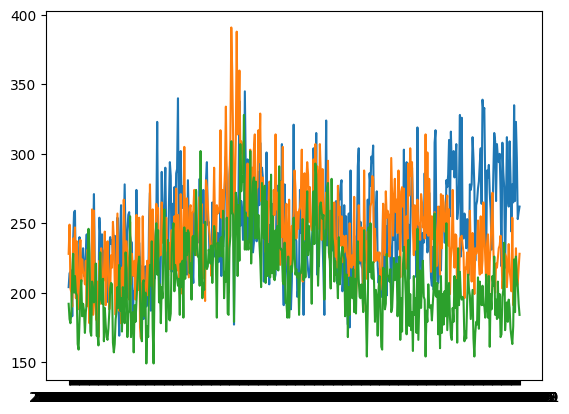

In [4]:
data_slice = data.iloc[:, 1:]

LOWER = 100
UPPER = 500
data_slice = data_slice[(data_slice < UPPER).all(axis=1) & (data_slice > LOWER).all(axis=1)]


NUM_TRAJ = 3
regression_slice = data_slice[NUM_TRAJ:NUM_TRAJ + 30]
data_slice = data_slice[:NUM_TRAJ]
data_slice_plot = data_slice.T

LAGS = [1, 6]

# plot the data
CUTOFF_T = 500
print(data_slice.shape)
plt.plot(data_slice.iloc[:, :CUTOFF_T].T)

In [5]:
# get random indices
# print(regression_slice)
import statsmodels.api as sm
regressors1 = []
regressors2 = []
for i in range(regression_slice.shape[0]):
    curr_data = regression_slice.iloc[i, :]
    reg1 = curr_data.shift(LAGS[0])
    reg2 = curr_data.shift(LAGS[1])

    reg_data = pd.concat([curr_data, reg1, reg2], axis=1)
    reg_data = reg_data.dropna()
    model = sm.OLS(reg_data.iloc[:, 0], reg_data.iloc[:, 1:])
    results = model.fit()
    # print(list(results.params))

    regressors1.append(list(results.params)[0])
    regressors2.append(list(results.params)[1])

regressors1 = np.array(regressors1).mean()
regressors2 = np.array(regressors2).mean()
print(regressors1, regressors2)

0.5692722824361343 0.42405574780832994


In [6]:
numpy_data = data_slice.to_numpy()
numpy_data # each row is a trajectory
N = numpy_data.shape[0]


data = []
data2 = []
t_idxs = []
Ns = []

for i in range(LAGS[-1], min(CUTOFF_T, data_slice.shape[1]) + LAGS[-1]):
    if i == LAGS[-1] or i == (min(CUTOFF_T, data_slice.shape[1]) - 1) + LAGS[-1]:
        # vstack data:
        data = np.vstack([data, numpy_data[:, i].reshape(-1, 1)]) if len(data) > 0 else numpy_data[:, i].reshape(-1, 1)
        test = np.hstack([numpy_data[:, i].reshape(-1, 1), np.zeros_like(numpy_data[:, i].reshape(-1, 1))])
        data2 = np.vstack([data2, np.hstack([numpy_data[:, i].reshape(-1, 1), (numpy_data[:, i-LAGS[-1]].reshape(-1, 1))])]) if len(data2) > 0 else np.hstack([numpy_data[:, i].reshape(-1, 1), np.zeros_like(numpy_data[:, i].reshape(-1, 1))])
        t_idxs += [i - LAGS[-1]] * numpy_data.shape[0]
    else:
        # select N randomly sampled points
        random_indices = np.random.choice(numpy_data.shape[0], N, replace=False)
        # data.append(numpy_data[random_indices, i])

        data = np.vstack([data, numpy_data[random_indices, i].reshape(-1, 1)])
        if i >= LAGS[-1]:
            data2 = np.vstack([data2, np.hstack([numpy_data[random_indices, i].reshape(-1, 1), (numpy_data[random_indices, i-LAGS[-1]].reshape(-1, 1))])])
        else:
            data2 = np.vstack([data2, np.hstack([numpy_data[random_indices, i].reshape(-1, 1), np.zeros_like(numpy_data[random_indices, i].reshape(-1, 1))])])
        t_idxs += [i - LAGS[-1]] * N
    
data = np.array(data)
data2 = np.array(data2)
t_idxs = np.array(t_idxs)
t_idxs = np.array(t_idxs)

T = min(CUTOFF_T, data_slice.shape[1])
t_final = T
dts = np.array([1] * (T - 1))



In [7]:
dt = 1
SCALING = 50

print(data.shape, data2.shape, t_idxs.shape, dts.shape)

s1 = gwot.ts.TimeSeries(x=data/SCALING, dt=dts, t_idx=t_idxs)
s2 = gwot.ts.TimeSeries(x=data2/SCALING, dt=dts, t_idx=t_idxs)

(1500, 1) (1500, 2) (1500,) (499,)


In [8]:
M = data_slice.shape[0] * 2

dim = 1
lamda_reg = .05
lamda_cst = 0.02
sigma_cst = 2.0/2
hid_weight = 5
sinkhorn_iters = 250
eta_final = 0.002
sigma_final = 0.5
temp_init = 100
temp_ratio = (1/5)**(1/2000)
fitType = 'Sinkhorn'
D = 0.001

UPPER_ = 300/SCALING
LOWER_ = 100/SCALING


forwardMap = torch.tensor([
    [regressors1, 0.,],
    [regressors2, 1.],
    ],device=device)


#Make forward/backward maps a class
class predictionMap():
    def forward(self,x):
        return x @ forwardMap #replace this with any desired function
        
    def backward(self,x):
        return x
pred = predictionMap() #If don't want to do prediction, can set to None
obs_idx = 2
g = lambda x: x[:, 0:obs_idx] # observation function


models_all = [pred_models.TrajLoss(pred, g, (UPPER_ - LOWER_) * torch.rand(T, M, dim + 1, device = device) + LOWER_,
                        torch.tensor(s2.x[:], device = device), obs_idx,
                        torch.tensor(s2.t_idx, device = device), 
                        dt = t_final/T, tau = D, sigma = None, M = M,
                        lamda_reg = lamda_reg, lamda_cst = lamda_cst, sigma_cst = sigma_cst, hid_weight = hid_weight,
                        branching_rate_fn = None,
                        sinkhorn_iters = 500, device = device,warm_start = True),
              models.TrajLoss((UPPER_ - LOWER_) * torch.rand(T, M, dim, device = device) + LOWER_,
                        torch.tensor(s1.x[:], device = device), dim,
                        torch.tensor(s1.t_idx, device = device), 
                        dt = t_final/T, tau = D, sigma = None, M = M,
                        lamda_reg = lamda_reg, lamda_cst = lamda_cst, sigma_cst = sigma_cst,
                        branching_rate_fn = None,
                        sinkhorn_iters = 500, device = device,warm_start = True)
    ]




In [9]:
n_iters = 1000
outputs_all = [pred_models.optimize(models_all[0], n_iter = n_iters, eta_final = eta_final, tau_final = D, sigma_final = sigma_final, N = M, temp_init = temp_init, temp_ratio = temp_ratio, dim = dim, tloss = models_all[0], print_interval = 50),
               models.optimize(models_all[1], n_iter = n_iters, eta_final = eta_final, tau_final = D, sigma_final = sigma_final, N = M, temp_init = temp_init, temp_ratio = temp_ratio, dim = dim, tloss = models_all[1], print_interval = 50)]


Iteration 0, Loss = -14.617, Primal loss = -8.888, Avg. iters = 323.246, eta = 0.200, temp = 100.000
Iteration 50, Loss = -31.957, Primal loss = -26.423, Avg. iters = 188.443, eta = 0.192, temp = 96.056
Iteration 100, Loss = -33.787, Primal loss = -28.163, Avg. iters = 157.447, eta = 0.185, temp = 92.268
Iteration 150, Loss = -33.950, Primal loss = -28.300, Avg. iters = 147.737, eta = 0.177, temp = 88.629
Iteration 200, Loss = -33.575, Primal loss = -27.967, Avg. iters = 129.812, eta = 0.170, temp = 85.134
Iteration 250, Loss = -33.078, Primal loss = -27.543, Avg. iters = 125.691, eta = 0.164, temp = 81.777
Iteration 300, Loss = -32.563, Primal loss = -27.068, Avg. iters = 112.162, eta = 0.157, temp = 78.552
Iteration 350, Loss = -31.947, Primal loss = -26.541, Avg. iters = 109.697, eta = 0.151, temp = 75.454
Iteration 400, Loss = -31.308, Primal loss = -26.007, Avg. iters = 95.854, eta = 0.145, temp = 72.478
Iteration 450, Loss = -30.690, Primal loss = -25.501, Avg. iters = 94.481, et

Text(0.5, 1.0, 'Objective: primal')

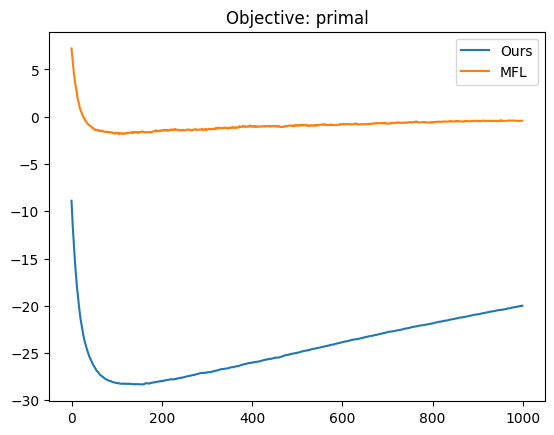

In [10]:
plt.plot(np.vstack([o[1] for o in outputs_all]).T)
plt.legend(["Ours", "MFL"])
plt.title("Objective: primal")

/var/folders/l4/490j2xpd14x0_7jxbfk49y180000gn/T/ipykernel_32057/349959072.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(time * np.ones(particles.shape[0]), particles.cpu().numpy()[:, time, 0].T * SCALING, c = color, alpha = 0.2, marker = '.', s = 2);


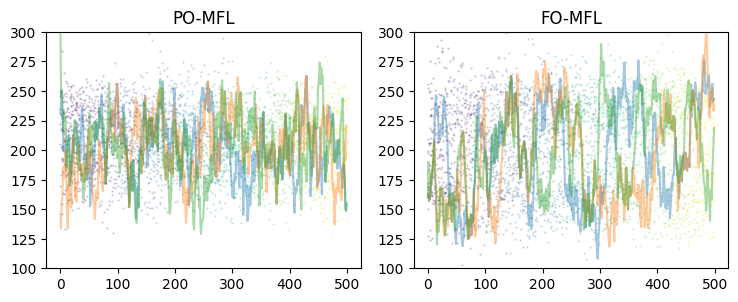

In [11]:
# N_paths = len(models_all[0].x)//5
N_paths = NUM_TRAJ
# N_paths = len(models_all[0].x)
plt.figure(figsize = (3*PLT_CELL, 1.25*PLT_CELL))
for (i, m) in enumerate(models_all):
    plt.subplot(1, 2, i+1)
    with torch.no_grad():
        paths = bs.sample_paths(None, N = N_paths, coord = True, x_all = m.x.cpu().numpy(), 
                            get_gamma_fn = lambda i : m.loss_reg.ot_losses[i].coupling().cpu(), num_couplings = T-1)
        # print(paths.shape)

        if i == 0:
            particles = m.x[:, :, 0].reshape(-1, T, 1)
        else:
            particles = m.x.reshape(-1, T, 1)

        for time in range(T):
            color_var = time / T
            # map to a color
            color = plt.cm.viridis(color_var)

            plt.scatter(time * np.ones(particles.shape[0]), particles.cpu().numpy()[:, time, 0].T * SCALING, c = color, alpha = 0.2, marker = '.', s = 2);
        plt.plot(paths[:, :, 0].T * SCALING, alpha = 0.4);
    if i == 1:
        plt.title("FO-MFL")
    else:
        
        plt.title("PO-MFL")
    y_min = 100
    y_max = 300
    plt.ylim(y_min, y_max)
plt.tight_layout()

In [12]:
import ot
NUM_TRIALS = 100
ground_truth = numpy_data[:, :T]

po_mfl = []
mfl = []

MULTIPLE = 1

for i in range(NUM_TRIALS):
    with torch.no_grad():
        paths = bs.sample_paths(None, N = ground_truth.shape[0] * MULTIPLE, coord = True, x_all = models_all[0].x.cpu().numpy(), 
                                get_gamma_fn = lambda i : models_all[0].loss_reg.ot_losses[i].coupling().cpu(), num_couplings = T-1)
    po_mfl_traj = paths[:, :, 0] * SCALING

    with torch.no_grad():
        paths1 = bs.sample_paths(None, N = ground_truth.shape[0] * MULTIPLE, coord = True, x_all = models_all[1].x.cpu().numpy(), 
                                get_gamma_fn = lambda i : models_all[1].loss_reg.ot_losses[i].coupling().cpu(), num_couplings = T-1)
    mfl_traj = paths1[:, :, 0] * SCALING

    po_mfl_dist = ot.dist(ground_truth, po_mfl_traj)
    mfl_dist = ot.dist(ground_truth, mfl_traj)

    po_mfl_cost = ot.emd2([], [], po_mfl_dist)
    mfl_cost = ot.emd2([], [], mfl_dist)

    po_mfl.append(po_mfl_cost)
    mfl.append(mfl_cost)

po_mfl = np.array(po_mfl)
mfl = np.array(mfl)

print("MFL: ", mfl.mean(), mfl.std())
print("PO-MFL: ", po_mfl.mean(), po_mfl.std())


MFL:  1804098.785168112 215859.8604729889
PO-MFL:  1267580.673175504 80869.28723648831
